# Reduction Notes and Programs
## ASTR 5150 HW 4
### by Brad Lyke

### Initial linux structure notes and commands:
- First step, make subfolder structure for the data.
- RAW includes the files as downloaded from the telescope.
- Run the following to make the directory structure:
  - ./mk_dir.sh
  - This makes raw,sci,flat,dark,bias,focus subfolders and moves everything into the raw folder. 

- Note, all file names and ranges are taken from log.txt in raw.
- These ARE NOT generalized number ranges. Specific to this data set.
- Copy the flats to the flat folder, renaming .fit as .fits (from raw)
  - cp a0{05..62}.* ../flat
  - ls ../flat
 
- Copy the bias frames to bias folder (from raw).
  - cp a{093..111}.* ../bias

- Copy the focus frames to the focus folder (from raw).
  - cp a0{64..73}.* ../focus
  - cp a{194..201}.* ../focus

- Copy the dark frames to the darks folder (from raw).
  - cp d0{01..15}.fits ../dark/

- Make science frame subfolder based on filters.
- This makes a folder for u,b,v,r,i,ha in the science directory.
  - ./mk_sci.sh

- Copy the Science frames to the respective filter folders in /sci/
- I made a csv of the science frames with filter from the logs (sci_list.dat)
  - SEE NEXT CELL

In [134]:
#I ran the following in ipython by hand. DON'T RUN THIS AGAIN.
#raw_env = './raw/'
#sci_list = np.loadtxt('sci_list.dat',dtype=bytes,delimiter=',').astype(str)
#for i in range(len(sci_list)):
    #sci_env = './sci/{}/'.format(sci_list[i,1])
    #fn_temp = 'a{0:03d}.fits'.format(int(sci_list[i,0]))
    #cmd = 'cp {}{} {}{}'.format(raw_env,fn_temp,sci_env,fn_temp)
    #os.system(cmd)
#This returned an error as a221-a236 didn't exist, but that's fine.

- Open a science frame and change the scale to find the overscan.
  - Overscan left = [0:52]
  - Overscan right = [2101:2200]
  - In python's 0-indexed system: [0:53] + [2101:2200]

- Now we start the programming portion. See cells afterwards.

In [96]:
from astropy.io import fits
import numpy as np
import numpy.polynomial.chebyshev as chb
import numpy.polynomial.legendre as lgd
from scipy.interpolate import UnivariateSpline as usp
import sys
import os
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['figure.figsize']=(20.0,10.0)
matplotlib.rc('font',size=20)

In [93]:
def show_img(show_file):
    cmd = 'ds9 {} &'.format(show_file)
    os.system(cmd)

This function (rem_oscan) just removes the overscan from the files. It doesn't do the analysis (that's further down).

In [95]:
def rem_oscan(infile):
    #Stuff goes here to remove the overscan
    sd = fits.open(infile)[0].data #opens the data for the image
    shdr = fits.open(infile)[0].header #opens the header for copying over`
    good_xpix = np.array([53,2100]) #The good, non-overscan pixels for WIRO Prime.
    out_array = np.zeros((2048,2048),dtype='int32') #holder array for good pixels
    overscan = np.zeros((2048,152),dtype='int32') #holder array for overscan pixels
    good_xarr = np.arange(good_xpix[0],good_xpix[1]+1,1) #Address range of good pix
    oscan_xarr = np.arange(0,2048,1)
    #This will copy the good pixels over to the out_array
    #overscan for each row will be fit to an 8th degree polynomial (fitfunc)
    #This fit will then be removed from the good pixels
    for i in range(2048):
        out_array[i,:] = sd[i,good_xpix[0]:good_xpix[1]+1] #Copy over good pixels
        overscan[i,0:good_xpix[0]] = sd[i,0:good_xpix[0]] #Make array of overscan left pixel values
        overscan[i,good_xpix[0]:152] = sd[i,good_xpix[1]+1:2200] #Array of overscan right pixel values

    oscan_mean = np.zeros(2048,dtype='f4')
    for i in range(2048):
        oscan_mean[i] = np.mean(overscan[i,:])

    #Find polyfit parameters for row-mean overscan
    pm_chb = chb.chebfit(oscan_xarr,oscan_mean,1)
    oscan_fit = chb.chebval(oscan_xarr,pm_chb) #Make an array of fit values using row numbers
    for i in range(2048):
        out_array[i,:] = out_array[i,:] - oscan_fit[i] #Remove the overscan function from good pixels
    #All pixels in the y-direction are good.

    out_hdu = fits.PrimaryHDU(out_array,header=shdr) #Make a new HDU for image
    ofile_str = infile.replace('.fits','_z.fits') #Output file rename
    out_hdu.writeto(ofile_str) #Write out the file

In [179]:
#This function will analyze the overscan throughout the night on the good science images 
#to see if there is a trend of some sort. There is only one set of bias frames, so we cannot
#do the same thing with them.
def oscan_timelyze():
    env = './sci'
    sci_list = np.loadtxt('sci_list.dat',dtype=bytes,delimiter=',').astype(str) #Loads as unicode
    num_sci = len(sci_list) - 16 #Only count the good science images from the list.
    good_xpix = np.array([53,2100]) #The good, non-overscan pixels for WIRO Prime.
    oscan_xarr = np.arange(0,2048,1)
    #Make a placeholder for a full-row mean of every column in the overscan. Do this for each
    #image, and save each image overscan means as a new column.
    total_oscan_means = np.zeros((2048,num_sci),dtype='int32')
    for i in range(num_sci):
        #Skip over files that didn't transfer over.
        if ((int(sci_list[i,0]) <= 236)&(int(sci_list[i,0])>=221)):
            continue
        overscan = np.zeros((2048,152),dtype='int32') #holder array for overscan pixels
        file_name = 'a{0:03d}.fits'.format(int(sci_list[i,0])) #File name of current science frame.
        file_temp = '{}/{}/{}'.format(env,sci_list[i,1],file_name) #actual location on my hdd
        sd = fits.open(file_temp)[0].data #Load the file
        overscan[:,0:good_xpix[0]] = sd[:,0:good_xpix[0]] #Make array of overscan l pixels
        overscan[:,good_xpix[0]:152] = sd[:,good_xpix[1]+1:2200] #Array of overscan r pixels
        for j in range(2048): #Populate the placeholder array that holds all science frame overscans.
            total_oscan_means[j,i] = np.mean(overscan[j,:])
    #We want to check nightly time response. Bin 5 overscans early, middle, and late in the night.
    binned_means = np.zeros((2048,3),dtype='int32')
    binned_means[:,0] = np.mean(total_oscan_means[:,0:5]) #Early night bin
    binned_means[:,1] = np.mean(total_oscan_means[:,63:68]) #Middle night bin
    binned_means[:,2] = np.mean(total_oscan_means[:,101:106]) #Late night bin.
    #Perform a first degree Chebyshev fit to the each binned set. Mostly likely a 0-degree fit,
    #but the first-degree will give another degree of freedom in case. Also plot each fit on the same
    #graph.
    for i in range(3):
        pm_chb = chb.chebfit(oscan_xarr,binned_means[:,i],1)
        y_fit = chb.chebval(oscan_xarr,pm_chb)
        print(pm_chb)
        lab = 'CHB: {}'.format(i)
        plt.plot(oscan_xarr,y_fit,label=lab)
    plt.legend()

[ 6.62000000e+02 -7.82136907e-16]
[ 6.62000000e+02 -7.82136907e-16]
[ 6.69000000e+02 -2.04035715e-16]


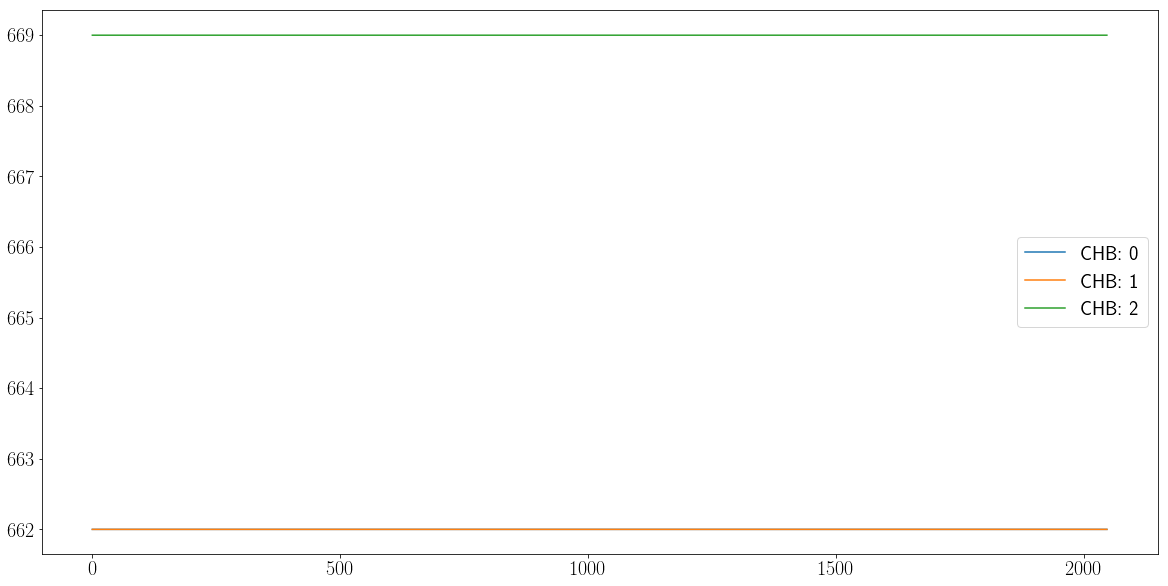

In [180]:
oscan_timelyze()

Above is the Chebyshev first-order polynomial fit parameters (numbers) and a plot of the three chebyshev fits. Each fit was 5 binned overscans of science images and each of the 3 fits represents a different portion of the night (with 0 being early and 2 being late). Note that the fits for 0 and 1 (early and middle night) are overlapped. It would appear from the overscans that bias levels do have some time dependence. However, as each image only has its own overscan removed, the time dependence of overscan is not important. In addition, the time dependence appears to only be about 7 adu, or a 1% change. As such, a single nightly master bias removed from all images rather than a time-dependent master bias would have little impact on later science frames.

The first degree Chebyshev fit is justified by the analysis in the next two cells (I did these cells out of order).

In [91]:
def oscan_analyze(infile):
    #If we are doing a fit check, we don't want to ouput the image yet. So it will just run
    #both fit types and see which is better.
    #Stuff goes here to remove the overscan
    env = '/d/zit1/5150/'
    sd = fits.open(infile)[0].data #opens the data for the image
    shdr = fits.open(infile)[0].header #opens the header for copying over`
    good_xpix = np.array([53,2100]) #The good, non-overscan pixels for WIRO Prime.
    out_array = np.zeros((2048,2048),dtype='int32') #holder array for good pixels
    overscan = np.zeros((2048,152),dtype='int32') #holder array for overscan pixels
    good_xarr = np.arange(good_xpix[0],good_xpix[1]+1,1) #Address range of good pix
    oscan_xarr = np.arange(0,2048,1)
    #This will copy the good pixels over to the out_array
    #overscan for each row will be fit to an 8th degree polynomial (fitfunc)
    #This fit will then be removed from the good pixels
    for i in range(2048):
        out_array[i,:] = sd[i,good_xpix[0]:good_xpix[1]+1] #Copy over good pixels
        overscan[i,0:good_xpix[0]] = sd[i,0:good_xpix[0]] #Make array of overscan left pixel values
        overscan[i,good_xpix[0]:152] = sd[i,good_xpix[1]+1:2200] #Array of overscan right pixel values

    oscan_mean = np.zeros(2048,dtype='f4')
    for i in range(2048):
        oscan_mean[i] = np.mean(overscan[i,:])
    
    #Find Chebyshev polyfit parameters for row-mean overscan
    fig1,ax1 = plt.subplots(nrows=2,ncols=2,sharex='col',sharey='row')
    for i in range(9):
        pm_chb = chb.chebfit(oscan_xarr,oscan_mean,i)
        print('Cheby {}:'.format(i),pm_chb)
        y_fit = chb.chebval(oscan_xarr,pm_chb)
        lab = 'CHB: {}'.format(i)
        ax1[0,0].plot(oscan_xarr,y_fit,label=lab)
    for i in range(9):
        pm_lgd = lgd.legfit(oscan_xarr,oscan_mean,i)
        print('Legendre {}:'.format(i),pm_lgd)
        y_fit = lgd.legval(oscan_xarr,pm_lgd)
        lab = 'LGD: {}'.format(i)
        ax1[0,1].plot(oscan_xarr,y_fit,label=lab)
    sm_arr = np.array([100,250,500,1000])
    for i in range(4):
        sm = sm_arr[i]
        spl3 = usp(oscan_xarr,oscan_mean,k=3,s=sm)
        lab = 'SPL3: {}'.format(sm)
        ax1[1,0].plot(oscan_xarr,spl3(oscan_xarr),label=lab)
    
    ax1[1,0].set_xlabel('Column Number')
    ax1[1,1].set_xlabel('Column Number')
    ax1[0,0].set_ylabel('Overscan (ADU)')
    ax1[1,0].set_ylabel('Overscan (ADU)')
    for i in range(2):
        for j in range(2):
            ax1[i,j].tick_params(axis='both',direction='in')
            if i == 0:
                ax1[i,j].legend(loc='upper right')
            else:
                ax1[i,j].legend(loc='lower right')
    fig1.subplots_adjust(wspace=0,hspace=0)

No handles with labels found to put in legend.


Cheby 0: [660.34156573]
Cheby 1: [ 6.60853791e+02 -5.00464806e-04]
Cheby 2: [ 6.61178461e+02 -1.45257407e-03  2.32562107e-07]
Cheby 3: [ 6.61362897e+02 -2.53509846e-03  8.93766591e-07 -1.07670491e-10]
Cheby 4: [ 6.61378289e+02 -2.68581615e-03  1.05952511e-06 -1.70662307e-10
  7.69318709e-15]
Cheby 5: [ 6.61346091e+02 -2.21232757e-03  2.49156438e-07  3.57372098e-10
 -1.37424321e-13  1.41785548e-17]
Cheby 6: [ 6.61273905e+02 -7.24021827e-04 -3.39148532e-06  3.91658767e-09
 -1.76793635e-12  3.64689137e-16 -2.85385590e-20]
Cheby 7: [ 6.61236951e+02  2.93555548e-04 -6.75375187e-06  8.48324895e-09
 -4.83677260e-12  1.44433145e-15 -2.19013618e-19  1.32929764e-23]
Cheby 8: [ 6.61187893e+02  2.03374950e-03 -1.42121561e-05  2.18592561e-08
 -1.70965924e-11  7.67518080e-15 -1.99492608e-18  2.78893567e-22
 -1.62188929e-26]
Legendre 0: [660.34156573]
Legendre 1: [ 6.60853791e+02 -5.00464806e-04]
Legendre 2: [ 6.61178461e+02 -1.45257407e-03  3.10082810e-07]
Legendre 3: [ 6.61362896e+02 -2.53509840e-0

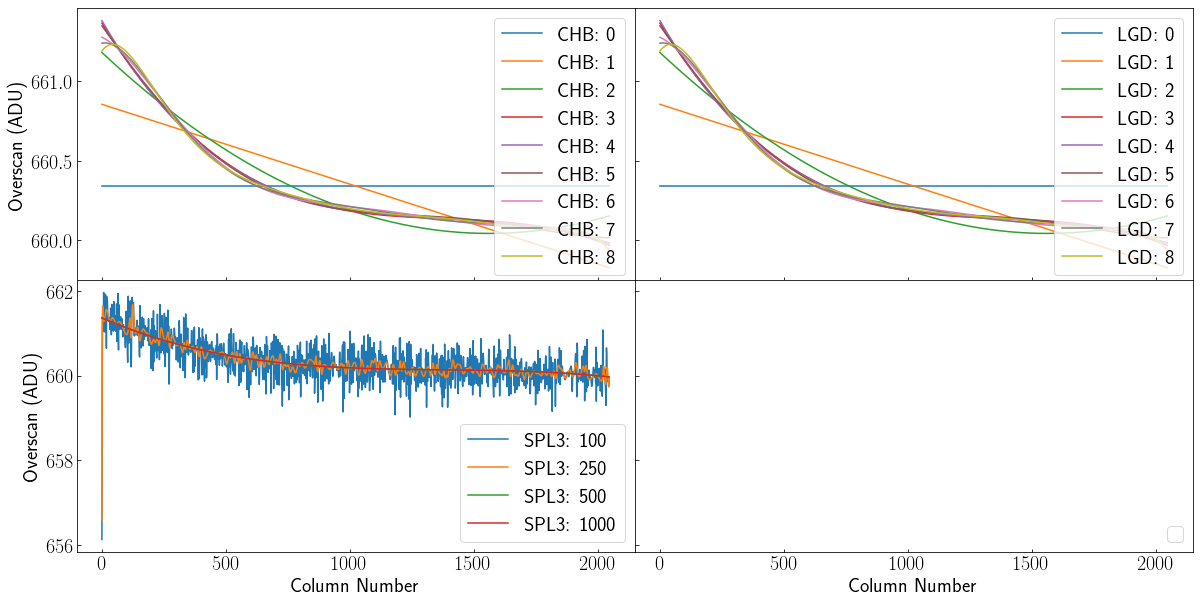

In [92]:
oscan_analyze('./sci/v/a120.fits')

In [100]:
#Remove the overscan from all files
folders = np.array(['bias','dark','flat','focus'])
colors = np.array(['u','b','v','r','i','ha'])
num_folders = len(folders)
num_colors = len(colors)
#Remove overscan in non-science frames.
for i in range(num_folders):
    loc = './{}/'.format(folders[i])
    gb_files = '{}*.fits'.format(loc)
    flist = glob.glob(gb_files)
    flsort = np.sort(flist)
    num_files = len(flsort)
    for j in range(num_files):
        temp_file = flsort[j]
        rem_oscan(temp_file)
    print('{} files are done.'.format(folders[i]))

#Remove overscan in science frames.
for i in range(num_colors):
    loc = './sci/{}/'.format(colors[i])
    gb_files = '{}*.fits'.format(loc)
    flist = glob.glob(gb_files)
    flsort = np.sort(flist)
    num_files = len(flsort)
    for j in range(num_files):
        temp_file = flsort[j]
        rem_oscan(temp_file)
    print('{} files are done.'.format(colors[i]))


bias files are done.
dark files are done.
flat files are done.
focus files are done.
u files are done.
b files are done.
v files are done.
r files are done.
i files are done.
ha files are done.


In [122]:
#Make a master median bias
#Only one set of bias images were taken, so a single image will have to do.
def mk_bias():
    file_loc = './bias/*_z.fits'
    file_list = glob.glob(file_loc)
    file_sort = np.sort(file_list)
    num_files = len(file_sort)
    bias_arr = np.zeros((2048,2048,num_files),dtype='f4')
    master_bias_arr = np.zeros((2048,2048),dtype='f4')
    #Make a 3D array for all of the bias files, each x/y plane is a file.
    for i in range(num_files):
        tfile_name = file_sort[i]
        temp_file = fits.open(tfile_name)[0].data
        bias_arr[:,:,i] = temp_file[:,:]
    #Take the median to make the master bias set.
    master_bias_arr = np.median(bias_arr,axis=2)
    
    mstbias_hdu = fits.PrimaryHDU(master_bias_arr) #Make a new HDU for image
    mstbias_str = './bias/masterbias_median.fits' #Output file rename
    mstbias_hdu.writeto(mstbias_str) #Write out the file
    

In [123]:
mk_bias()
show_img('./bias/masterbias_median.fits')

In [260]:
def bias_look():
    sd = fits.open('./bias/masterbias_median.fits')[0].data
    desc_arr = np.zeros(1,dtype=[('MIN_ADU','f4'),('MAX_ADU','f4'),('RANGE_ADU','f4'),
                                ('MEAN_ADU','f4'),('STD_ADU','f4'),('MED_ADU','f4'),('RMS','f4')])
    desc_arr['MIN_ADU'] = np.amin(sd)
    desc_arr['MAX_ADU'] = np.amax(sd)
    desc_arr['RANGE_ADU'] = np.amax(sd) - np.amin(sd)
    desc_arr['MEAN_ADU'] = np.mean(sd)
    desc_arr['STD_ADU'] = np.std(sd)
    desc_arr['MED_ADU'] = np.median(sd)
    desc_arr['RMS'] = np.sqrt(np.mean(np.square(sd)))
    print(np.transpose(desc_arr.dtype.names))
    print(desc_arr)

In [261]:
bias_look()

['MIN_ADU' 'MAX_ADU' 'RANGE_ADU' 'MEAN_ADU' 'STD_ADU' 'MED_ADU' 'RMS']
[(-9., 33., 42., 3.0040588, 2.6835275, 2., 4.0281115)]


There is only one bias image set, so I can't look at time dependence of the bias (other than through the overscan above). The above description is for the master bias after the overscan has been removed. As such, the bias levels are considerably less than might be expected. Overall, the bias std_adu is ~2.7. So by subtracting the master bias from the images I will be adding ~2.7 adu (I can't computer electron counts without a gain). Below I look at the RMS and row/column plots, and a subregion plot for the master bias. After this I remove the master bias from images.

Note: I did the problems out of order, but I think the important part of number 3 was learning to plot row/columns.

In [314]:
#This is a utility function with the job of finding the statistical information of an array.
#Mainly useful for flats, darks, and biases. Not as useful for a science frame.
def desc_array(arr_in,out_table=False):
    desc_arr = np.zeros(1,dtype=[('MIN_ADU','f4'),('MAX_ADU','f4'),('RANGE_ADU','f4'),
                                ('MEAN_ADU','f4'),('STD_ADU','f4'),('MED_ADU','f4'),('RMS','f4')])
    desc_arr['MIN_ADU'] = np.amin(arr_in)
    desc_arr['MAX_ADU'] = np.amax(arr_in)
    desc_arr['RANGE_ADU'] = np.amax(arr_in) - np.amin(arr_in)
    desc_arr['MEAN_ADU'] = np.mean(arr_in)
    desc_arr['STD_ADU'] = np.std(arr_in)
    desc_arr['MED_ADU'] = np.median(arr_in)
    desc_arr['RMS'] = np.sqrt(np.mean(np.square(arr_in)))
    if out_table == True:    
        for i in range(7):
            name_temp = desc_arr.dtype.names[i]
            print('{0:9} | {1:7.3f} adu'.format(name_temp,desc_arr[name_temp][0]))
    return desc_arr

The code below, along with the output is of 4 columns, 4 rows, and a single box at the center of the bias file for a099.fits. The mean and rms values for each plot are annotated on the plot. The box region is a table of information above the plots.

File      | a099.fits
BOX REGION
ROWS 1000:1200 | COLS 924:1124
MIN_ADU   | 599.000 adu
MAX_ADU   | 728.000 adu
RANGE_ADU | 129.000 adu
MEAN_ADU  | 671.025 adu
STD_ADU   |   8.672 adu
MED_ADU   | 671.000 adu
RMS       | 220.178 adu


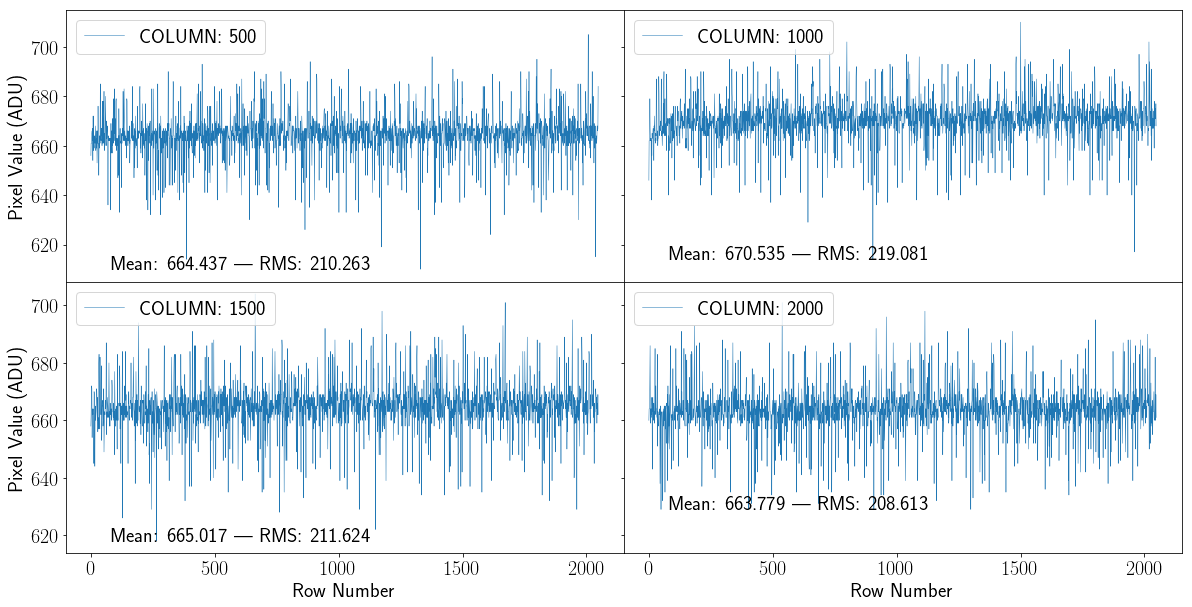

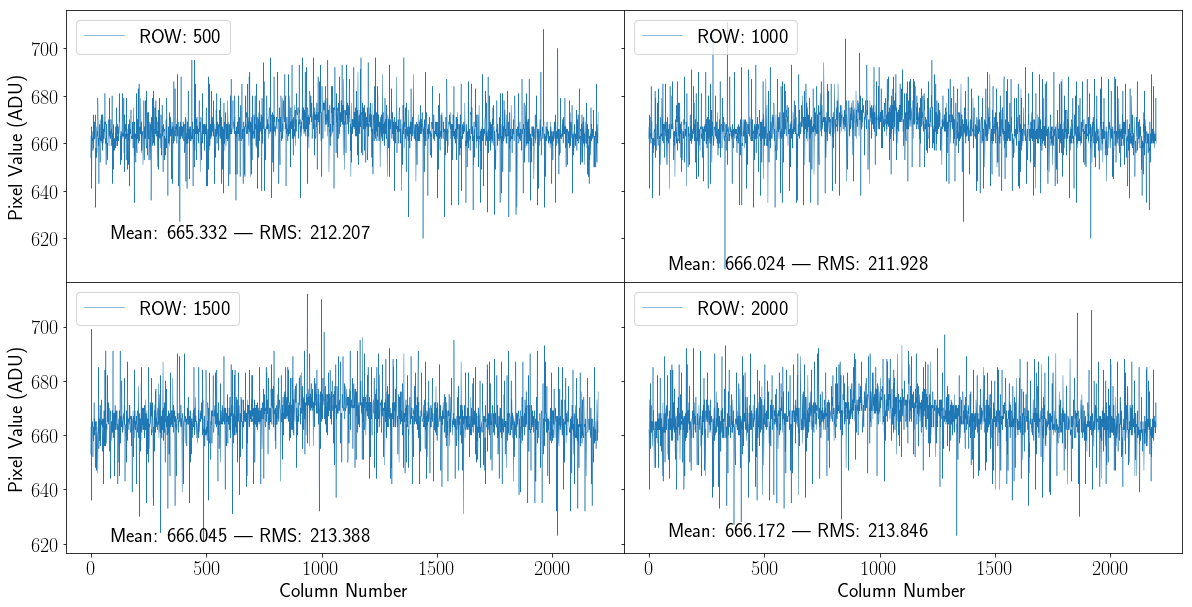

In [317]:
def bias_plot():
    file_loc = './bias'
    file_num = 'a099.fits'
    file_name = '{}/{}'.format(file_loc,file_num)
    bias_file = fits.open(file_name)[0].data #Note, this is not overscan subtracted.
    bias_head = fits.open(file_name)[0].header
    rc_to_plot = np.array([500,1000,1500,2000]) #Individual rows and columns to plot
    #Region to plot: Rows 1000:1200, Cols 924:1124
    print('File      | {}'.format(file_num))
    fig1,ax1 = plt.subplots(nrows=2,ncols=2,sharex='col',sharey='row')
    fig2,ax2 = plt.subplots(nrows=2,ncols=2,sharex='col',sharey='row')
    for i in range(4):
        lab = 'COLUMN: {}'.format(rc_to_plot[i])
        col_stats = desc_array(bias_file[:,rc_to_plot[i]])
        tstring = r'Mean: {0:7.3f} | RMS: {1:7.3f}'.format(col_stats['MEAN_ADU'][0],col_stats['RMS'][0])
        if i < 2:
            ax1[0,i].plot(np.arange(0,2048,1),bias_file[:,rc_to_plot[i]],label=lab,linewidth=0.5)
            ax1[0,i].legend(loc='upper left')
            ax1[0,i].annotate(tstring,xy=(0,int(col_stats['MIN_ADU'][0])),xytext=(20,0),textcoords='offset points')
        else:
            ax1[1,i-2].plot(np.arange(0,2048,1),bias_file[:,rc_to_plot[i]],label=lab,linewidth=0.5)
            ax1[1,i-2].legend(loc='upper left')
            ax1[1,i-2].annotate(tstring,xy=(0,int(col_stats['MIN_ADU'][0])),xytext=(20,0),textcoords='offset points')
        
    ax1[0,0].set_ylabel('Pixel Value (ADU)')
    ax1[1,0].set_ylabel('Pixel Value (ADU)')
    ax1[1,0].set_xlabel('Row Number')
    ax1[1,1].set_xlabel('Row Number')
    for i in range(4):
        lab = 'ROW: {}'.format(rc_to_plot[i])
        row_stats = desc_array(bias_file[rc_to_plot[i],:])
        tstring = r'Mean: {0:7.3f} | RMS: {1:7.3f}'.format(row_stats['MEAN_ADU'][0],row_stats['RMS'][0])
        if i < 2:
            ax2[0,i].plot(np.arange(0,2200,1),bias_file[rc_to_plot[i],:],label=lab,linewidth=0.5)
            ax2[0,i].legend(loc='upper left')
            ax2[0,i].annotate(tstring,xy=(0,int(row_stats['MIN_ADU'][0])),xytext=(20,0),textcoords='offset points')
        else:
            ax2[1,i-2].plot(np.arange(0,2200,1),bias_file[rc_to_plot[i],:],label=lab,linewidth=0.5)
            ax2[1,i-2].legend(loc='upper left')
            ax2[1,i-2].annotate(tstring,xy=(0,int(row_stats['MIN_ADU'][0])),xytext=(20,0),textcoords='offset points')
    
    ax2[0,0].set_ylabel('Pixel Value (ADU)')
    ax2[1,0].set_ylabel('Pixel Value (ADU)')
    ax2[1,0].set_xlabel('Column Number')
    ax2[1,1].set_xlabel('Column Number')
    fig1.subplots_adjust(wspace=0,hspace=0)
    fig2.subplots_adjust(wspace=0,hspace=0)
    
    print('BOX REGION')
    print('ROWS 1000:1200 | COLS 924:1124')
    box_stats = desc_array(bias_file[1000:1200,924:1124],out_table=True)
bias_plot()

In [131]:
#This function removes the master bias frame from a file and saves a new file with _zb after.
def rem_bias(infile):
    fdata = fits.open(infile)[0].data #Open the data file
    fhead = fits.open(infile)[0].header #Open the data header
    bias_file = fits.open('./bias/masterbias_median.fits')[0].data #Open the bias file

    out_data = fdata - bias_file #Do the subtraction
    
    fd_hdu = fits.PrimaryHDU(out_data,header=fhead) #New HDU for the new file
    fd_str = infile.replace('_z.fits','_zb.fits') #New file name
    fd_hdu.writeto(fd_str) #Write out the file

In [132]:
#Remove the bias frames from the darks.
dlist = glob.glob('./dark/*_z.fits')
dark_sort = np.sort(dlist)
num_darks = len(dark_sort)
for i in range(num_darks):
    tfile_name = dark_sort[i]
    rem_bias(tfile_name)
print('Dark bias subtraction done.')

Dark bias subtraction done.


- Looking at the dark frames after the bias and overscan has been removed:
  - dfits ./dark/*_zb.fits | fitsort EXPTIME
  - This me all of the exposure times so I could choose one of each to look at mins and maxs.
- Choose the following: 
  - Short: d003
  - Medium: d008
  - Long: d012

In [250]:
def dark_look(normalize=0,file_list=np.array(['d003_zb.fits','d008_zb.fits','d012_zb.fits']),master=False):
    look_files = file_list
    num_looks = len(look_files)
    if master == False:
        desc_arr = np.zeros(num_looks,dtype=[('MIN_ADU','f4'),('MAX_ADU','f4'),('RANGE_ADU','f4'),
                                ('MEAN_ADU','f4'),('STD_ADU','f4'),('MED_ADU','f4'),('EXPTIME','i4')])
    else:
        desc_arr = np.zeros(num_looks,dtype=[('MIN_ADU','f4'),('MAX_ADU','f4'),('RANGE_ADU','f4'),
                                ('MEAN_ADU','f4'),('STD_ADU','f4'),('MED_ADU','f4'),('RMS','f4')])
    for i in range(num_looks):
        if master == False:
            temp_file = './dark/{}'.format(look_files[i])
        else:
            temp_file = look_files[i]
        dark_temp = fits.open(temp_file)[0].data
        dark_hdr = fits.open(temp_file)[0].header
        #dark_temp = dark_temp - np.amin(dark_temp) #Boost everything by non-zero min value.
        if normalize == 1:
            dark_temp = dark_temp / dark_hdr['EXPTIME'] #Assume dark current is linear with time.
        desc_arr['MIN_ADU'][i] = np.amin(dark_temp)
        desc_arr['MAX_ADU'][i] = np.amax(dark_temp)
        desc_arr['RANGE_ADU'][i] = np.amax(dark_temp) - np.amin(dark_temp)
        desc_arr['MEAN_ADU'][i] = np.mean(dark_temp)
        desc_arr['STD_ADU'][i] = np.std(dark_temp)
        desc_arr['MED_ADU'][i] = np.median(dark_temp)
        if master == False:
            desc_arr['EXPTIME'][i] = dark_hdr['EXPTIME']
        else:
            desc_arr['RMS'][i] = np.sqrt(np.mean(np.square(dark_temp)))
    print(np.transpose(desc_arr.dtype.names))
    print(desc_arr)
    print(look_files)

In [231]:
dark_look()

['MIN_ADU' 'MAX_ADU' 'RANGE_ADU' 'MEAN_ADU' 'STD_ADU' 'MED_ADU' 'EXPTIME']
[(0.,  2839.,  2839., 36.825287,  4.6850204, 37.,   2)
 (0.,  3958.,  3958., 37.442654,  4.6945286, 37.,   5)
 (0., 17643., 17643., 34.615074, 12.513345 , 34., 300)]


In [232]:
dark_look(normalize=1)

['MIN_ADU' 'MAX_ADU' 'RANGE_ADU' 'MEAN_ADU' 'STD_ADU' 'MED_ADU' 'EXPTIME']
[(0., 1419.5 , 1419.5 , 18.412643  , 2.3425102 , 18.5       ,   2)
 (0.,  791.6 ,  791.6 ,  7.488531  , 0.9389057 ,  7.4       ,   5)
 (0.,   58.81,   58.81,  0.11538358, 0.04171115,  0.11333334, 300)]


The high levels of MAX_ADU tell me there are cosmic rays in each of the frames. I can't do sigma clipping until I combine them. The flattening and cosmic ray removal have to happen as one step.

Using the mean adu, however, scaled with exposure times gives me an estimated 0.04 ADU per second (not electrons).

In [217]:
from astropy.stats import mad_std #Standard deviation from median absolute deviation.

def sigclip(in_arr,upper=3.0,lower=3.0,avg_func = np.median, std_func=mad_std,return_margins=False):
    temp_data = np.ravel(in_arr)
    wgood = np.where((np.isnan(temp_data)==False)&(np.isinf(temp_data)==False))[0]
    temp_data = temp_data[wgood]
    sdelt = 1
    
    while sdelt:
        temp_dev = std_func(temp_data)
        temp_avg = avg_func(temp_data)
        ognum_vals = len(temp_data)
        lower_margin = temp_avg - (lower * temp_dev)
        upper_margin = temp_avg + (upper * temp_dev)
        wkeep = np.where((temp_data > lower_margin)&(temp_data<upper_margin))[0]
        temp_data = temp_data[wkeep]
        sdelt = ognum_vals - len(temp_data)
    
    if return_margins == True:
        return temp_data, lower_margin, upper_margin
    else:
        return temp_data


This is just a quick sigma-clipping algorithm I "wrote" (adapted from wirotools.py).

In [219]:
stest = fits.open('./dark/d003_zb.fits')[0].data
td,lm,um = sigclip(stest[50,:],return_margins=True)
print(td,lm,um)

[ 7.  7.  0. ... -2. -4.  4.] -7.895613311033612 9.895613311033612


In [245]:
import progressBar as pb #I wrote this, makes a filling progress bar in the terminal.

def mk_dark():
    file_list = glob.glob('./dark/*_zb.fits')
    flsort = np.sort(file_list)
    num_darks = len(flsort)
    dark_arr = np.zeros((2048,2048,num_darks),dtype='f4')
    norm_dark_arr = np.zeros((2048,2048,num_darks),dtype='f4')
    mdark_arr = np.zeros((2048,2048,4),dtype='f4')
    exp_arr = np.zeros(num_darks,dtype='int16')
    #Load all dark images into the 3D array. Leave them sorted so I can retrieve exposure time
    #later and normalize them all.
    for i in range(num_darks):
        temp_name = flsort[i]
        temp_file = fits.open(temp_name)[0].data
        temp_hdr = fits.open(temp_name)[0].header
        dark_arr[:,:,i] = temp_file[:,:]
        exp_arr[i] = temp_hdr['EXPTIME']
        norm_dark_arr[:,:,i] = temp_file[:,:] / temp_hdr['EXPTIME'] #normalize the dark by exposure time.
    #These darks are automatically weighted
    #Make an average dark combine. No sigma clipping used.
    mdark_arr[:,:,0] = np.average(norm_dark_arr[:,:,:],axis=2)
    #Make a median dark combine, no sigma clipping.
    mdark_arr[:,:,1] = np.median(norm_dark_arr[:,:,:],axis=2)
    
    #Make an average dark combine with 3 sigma clipping.
    #Make a median dark combine with 3 sigma clipping.
    for i in range(2048):
        for j in range(2048):
            well_temp = norm_dark_arr[i,j,:]
            well_av_clip = sigclip(well_temp,avg_func=np.mean,std_func=np.std) #mean sigma clipping
            well_avg = np.mean(well_av_clip)
            well_med = np.median(well_av_clip)
            if ((np.isnan(well_avg) == True)|(np.isinf(well_avg) == True)):
                well_avg = 0
            if ((np.isnan(well_med) == True)|(np.isinf(well_med) == True)):
                well_med = 0
            mdark_arr[i,j,2] = well_avg
            mdark_arr[i,j,3] = well_med
        pb.pbar(i,2048)
    #Write out the four master dark files.
    names_temp = np.array(['mean','medn','mnsc','mdsc'])
    for i in range(4):
        mstdark_hdu = fits.PrimaryHDU(mdark_arr[:,:,i]) #Make a new HDU for image
        mstdark_str = './dark/masterdark_{}.fits'.format(names_temp[i]) #Output file rename
        mstdark_hdu.writeto(mstdark_str) #Write out the file

In [246]:
mk_dark()

Record:    15/2,048 | Percent: [>                                       ]   1%

/usr/local/Anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/Anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/Anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/Anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/Anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Record: 2,048/2,048 | Percent: [=======================================>] 100%

One of the values in the 16th row, for some reason, is dividing by zero. I don't know where it would do so, but it seems to be fine.

In [251]:
mdarklist = np.array(glob.glob('./dark/masterdark*.fits'))
dark_look(file_list=mdarklist,master=True)

['MIN_ADU' 'MAX_ADU' 'RANGE_ADU' 'MEAN_ADU' 'STD_ADU' 'MED_ADU' 'RMS']
[(-8.583555, 93.81645  , 102.40001 , 0.1355854 , 0.43542394, 0.14111112, 0.4560455 )
 (-7.4     ,  2.4      ,   9.8     , 0.02303028, 0.16587357, 0.        , 0.16746473)
 (-8.583555,  2.6368892,  11.220445, 0.123679  , 0.39992264, 0.11977778, 0.41861013)
 (-7.4     ,  2.4      ,   9.8     , 0.02213948, 0.16305572, 0.        , 0.16455184)]
['./dark/masterdark_mean.fits' './dark/masterdark_medn.fits'
 './dark/masterdark_mnsc.fits' './dark/masterdark_mdsc.fits']


Each row above is a different method of dark combine. The first row is the straight Mean, the second row is the straight Median, the third row is the sigma-clipped Mean, and the last row is the sigma-clipped Median. Looking at the RMS values, the two median combines are much better. Of these two, the sigma-clipped median is better.

Looking at the mean_adu for the sigma-clipped median dark, the dark current is ~0.02 adu/sec, while the noise (std_adu) is ~0.16 adu/sec. Overall the noise is 8 times higher than the dark signal, which is expected of modern, cooled CCDs.